<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Template and tests for an LSTM Auto-Encoder


In [ ]:
import numpy as np
import scipy
from scipy.stats import special_ortho_group
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import LSTM, Layer
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed, Input, Lambda, Masking
import keras.backend as K
import tensorflow as tf


#### create some fake data



In [ ]:
dim = 30
Nsamples = 50000
eig = np.logspace(-3,3,dim)
R   = scipy.stats.special_ortho_group.rvs(dim)
cov = np.dot(R,np.dot(np.diag(eig), R.T))
L   = np.linalg.cholesky(cov)

In [ ]:
data  = np.expand_dims(np.einsum('jk,ik->ij',L,np.random.randn(Nsamples,dim),optimize=True),-1)
masks = np.random.random(data.shape)<0.75

In [ ]:
m_data = data*masks

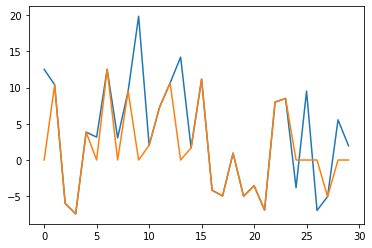

In [ ]:
plt.plot(data[0])
plt.plot(m_data[0])

In [ ]:
data_train = data[0:30000]
data_val   = data[30000:40000]
data_test  = data[40000:50000]

### write a simple LSTM model

In [ ]:
class bottleneck(Layer):
    def __init__(self, units, dim, **kwargs):
        self.units  = units
        self.dim    = dim
        self.LSTM   = LSTM(units, return_sequences=False)
        self.Repeat = RepeatVector(dim)
        super(bottleneck, self).__init__(**kwargs)

    def call(self, inputs):
        return self.Repeat(self.LSTM(inputs))

    def compute_mask(self, inputs, mask=None):
        return mask


input = Input(shape=(dim, 1))
x     = Masking(mask_value=0)(input)
x     = bottleneck(units=10, dim=dim)(x)
x     = LSTM(10, return_sequences=True)(x)
x     = Dense(1)(x)
lstm_ae = Model(inputs=input, outputs=x)
lstm_ae.compile(optimizer='adam', loss='mse')
print(lstm_ae.summary())

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 30, 1)]           0         
_________________________________________________________________
masking_6 (Masking)          (None, 30, 1)             0         
_________________________________________________________________
bottleneck (bottleneck)      (None, 30, 10)            480       
_________________________________________________________________
lstm_27 (LSTM)               (None, 30, 10)            840       
_________________________________________________________________
dense_9 (Dense)              (None, 30, 1)             11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
for i, l in enumerate(lstm_ae.layers):
    print(f'layer {i}: {l}')
    print(f'has input mask: {l.input_mask}')
    print(f'has output mask: {l.output_mask}')

layer 0: <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f1634120b38>
has input mask: None
has output mask: None
layer 1: <tensorflow.python.keras.layers.core.Masking object at 0x7f163409fc18>
has input mask: None
has output mask: Tensor("masking_6/Squeeze:0", shape=(None, 30), dtype=bool)
layer 2: <__main__.bottleneck object at 0x7f16340b0d30>
has input mask: Tensor("masking_6/Squeeze:0", shape=(None, 30), dtype=bool)
has output mask: Tensor("masking_6/Squeeze:0", shape=(None, 30), dtype=bool)
layer 3: <tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x7f163409f7b8>
has input mask: Tensor("masking_6/Squeeze:0", shape=(None, 30), dtype=bool)
has output mask: Tensor("masking_6/Squeeze:0", shape=(None, 30), dtype=bool)
layer 4: <tensorflow.python.keras.layers.core.Dense object at 0x7f1634166a20>
has input mask: Tensor("masking_6/Squeeze:0", shape=(None, 30), dtype=bool)
has output mask: Tensor("masking_6/Squeeze:0", shape=(None, 30), dtype=bool)


In [ ]:
history = lstm_ae.fit(data_train, data_train, validation_data=(data_val, data_val), batch_size=16, epochs=20, verbose=2)

Epoch 1/20
1875/1875 - 14s - loss: 7.7363 - val_loss: 7.5793
Epoch 2/20
1875/1875 - 14s - loss: 7.5775 - val_loss: 7.1976
Epoch 3/20
1875/1875 - 14s - loss: 7.4396 - val_loss: 7.1402
Epoch 4/20
1875/1875 - 13s - loss: 7.3168 - val_loss: 7.0252
Epoch 5/20
1875/1875 - 13s - loss: 7.2082 - val_loss: 7.1592
Epoch 6/20
1875/1875 - 14s - loss: 7.0406 - val_loss: 7.2772
Epoch 7/20
1875/1875 - 13s - loss: 6.9284 - val_loss: 6.9162
Epoch 8/20
1875/1875 - 13s - loss: 6.7963 - val_loss: 7.1740
Epoch 9/20
1875/1875 - 13s - loss: 6.6814 - val_loss: 6.6967
Epoch 10/20
1875/1875 - 13s - loss: 6.5505 - val_loss: 6.1006
Epoch 11/20
1875/1875 - 13s - loss: 6.4728 - val_loss: 6.1469
Epoch 12/20
1875/1875 - 13s - loss: 6.3085 - val_loss: 6.2557
Epoch 13/20
1875/1875 - 13s - loss: 6.2206 - val_loss: 6.1316
Epoch 14/20
1875/1875 - 13s - loss: 6.1591 - val_loss: 6.1790
Epoch 15/20
1875/1875 - 13s - loss: 6.0341 - val_loss: 5.6317
Epoch 16/20
1875/1875 - 13s - loss: 5.9814 - val_loss: 5.9422
Epoch 17/20
1875/

In [ ]:
def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
  # create an empty model
  new_model = Sequential()
  for ix in range(starting_layer_ix, ending_layer_ix + 1):
    curr_layer = main_model.get_layer(index=ix)
    # copy this layer over to the new model
    new_model.add(curr_layer)
  return new_model

In [ ]:
encoder = Model(inputs=lstm_ae.inputs, outputs=lstm_ae.layers[1].output)
encoded = encoder.predict(data_val)
# decoder = extract_layers(model, 1, -1)
recon   = lstm_ae.predict(data_test)

In [ ]:
encoded.shape

(10000, 30, 1)

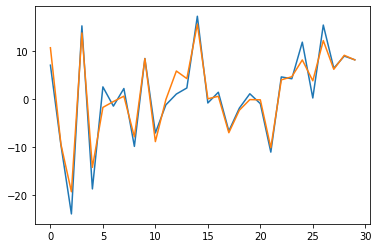

In [ ]:
plt.plot(data_test[0])
plt.plot(recon[0])